In [10]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import re
import sys
import time
from typing import *
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf


# data functions
import data_functions_to_transfer_to_pipeline as dtmp

##  IMPORT DATA PIPELINE PIECES

path_sdp = "/Users/usuario/git/sisepuede_data_pipeline"
if path_sdp not in sys.path:
    sys.path.append(path_sdp)

import lib.data_objects as do
import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib.data_construction_utilities as util



# Setup SISEPUEDE and SISEPUEDEDataRepository Classes

In [757]:
import sisepuede.manager.sisepuede_file_structure as sfs
importlib.reload(sc)
importlib.reload(sfs.ma.mv)
importlib.reload(sfs.ma)
importlib.reload(dc.sc)
importlib.reload(dc)

##  SISEPUEDE

# get the file structure and model attributes
file_struct = sfs.SISEPUEDEFileStructure()
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# get data constructs and local repository
construct = dc.SISEPUEDEDataConstructs()
repo = pu.Repository(
    {
        "local": {
            "path": "/Users/usuario/SISEPUEDE_DATA_REPOSITORY"
        }
    }
)

##  Setup files and Inputs Reader, used to read in IEA directories

In [741]:
importlib.reload(pu)


##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("sisepuede_inputs_iran_raw.csv")
fp_data_inputs = dir_data.joinpath("sisepuede_inputs_iran.csv")
fp_data_inputs_modified = dir_data.joinpath("sisepuede_inputs_iran_modified.csv")

fp_config = dir_cur.joinpath("config_data_pipeline.yaml")
fp_cw_iea_fuel_to_ssp = pathlib.Path(file_struct.dir_ref).joinpath("data_crosswalks", "iea_fuel_categories.csv")



# get the inputs reader object
reader = pu.InputsReader(
    str(fp_config),
    sisepuede_constructs = construct,
    repository = repo,
    stop_on_error = True,
)

In [699]:
def get_regular_expressions_for_iea_csvs(
    reader: pu.InputsReader,
    key_var: str,
    key_regex_csv: str = "regex_csv",
    key_regex_field_rename: str = "regex_field_rename",
) -> Tuple:
    """
    Retrieve regular expressions for file matching and associated field
        for the variable specified in key (input.VARIABLENAME)
    """

    # try CSVs
    regex_csv = reader.config.get(f"{key_var}.{key_regex_csv}")
    if regex_csv is not None:
        regex_csv = re.compile(regex_csv)

    # try field for fuels
    regex_field = reader.config.get(f"{key_var}.{key_regex_field_rename}")
    if regex_field is not None:
        regex_field = re.compile(regex_field)
    
    out = (regex_csv, regex_field)

    return out



def get_electricity_generation_by_source(
    reader: pu.InputsReader,
    key_var: str = "iea_electricity_generation_by_source",
) -> pd.DataFrame:
    """
    Retrieve the Electtricity Generation by Source data frame
    """
    repo.get_path(
        reader.config.get("inputs.iea_electricity_generation_by_source.repo.path")
    )

get_regular_expressions_for_iea_csvs(
    reader,
    "inputs.iea_electricity_generation_by_source"
)
    

(re.compile(r'International Energy Agency - electricity generation sources in (.*\D).csv',
            re.UNICODE),
 re.compile(r'electricity generation sources in (.*\D$)', re.UNICODE))

In [736]:
#reader.get_inputs_param("iea_electricity_generation_by_source", "regex_csv")
type(construct)
type(reader)

lib.process_utilities.InputsReader

In [779]:
def combine_iea_csvs_to_table(
    reader: pu.InputsReader,
    constructs: dc.SISEPUEDEDataConstructs,
    input_dataset: str,
    default_field_renamed: str = "iea_fuel",
    fillval: Union[float, int, None] = None,
    key_config_field_index_rename: str = "field_iea_index_renamed",
) -> Union[pd.DataFrame, None]:
    """
    Using a reader, combine IEA individiual CSVs

    Function Arguments
    ------------------
    - reader: InputsReader storing input data
    - constructs: SISEPUEDE constructs with access to regions, 
        model_attributes, etc.
    - input_dataset: input dataset (first-level key under reader.inputs) 
        to retrieve
        
    Keyword Arguments
    -----------------
    - default_field_renamed: default field name to use for renaming
        IEA fields if not specified in the configuration. In each of the 
        datasets, a key variable indexing field is named with 
        country-specific information. This needs to be renamed to something 
        generic to allow for concatenation.
    - fillval: optional value to use for filling values
    - key_config_field_index_rename: key in the configuration below the 
        dataset storing the new index field name
    """

    # get regular expressions
    (regex_csv, regex_field) = get_regular_expressions_for_iea_csvs(
        reader,
        f"{reader.key_inputs}.{input_dataset}"
    )

    # check path--if not available 
    fp_read = reader.dict_paths_full.get(input_dataset)
    if fp_read is None:
        return None


    # otherwise, get available files and get the new index field name
    files = [
        x for x in os.listdir(fp_read) 
        if regex_csv.match(x) is not None
    ]    
    
    files.sort() # sort so that we don't have to 

    
    field_index_new = (
        reader
        .config
        .get(
            f"{reader.key_inputs}.{input_dataset}.{key_config_field_index_rename}",
            return_on_none = default_field_renamed,
        )
    )


    ##  ITERATE OVER FILES TO BUILD
    
    df_out = []

    for fn in files:
        # set path to read
        fp_file = fp_read.joinpath(fn)

        ##  CHECK THE REGION
        
        region_base = regex_csv.match(fn).groups()[0]
        region = (
            construct
            .regions
            .data_func_try_isos_from_countries(
                region_base, 
                missing_iso_flag = "MISSING",
            )
        )

        # region not found
        if region[0] == "MISSING":
            warnings.warn(
                f"""WARNING: region '{region_base}' not found. Check the 
                name and ppotentially update the IEA regions dictionary ar
                support_classes.Regions `dict_iea_countries_lc_to_regions`.
                """
            )
            continue

        region = region[0]

        

        # try reading the file in
        try:
            df = pd.read_csv(fp_file)
        except:
            continue

        # next, let's get the column we need to rename
        field_rename = [x for x in df.columns if regex_field.match(x) is not None]
        if len(field_rename) > 1:
            warnings.warn(
                f"WARNING: multiple IEA index fields fund at path '{fp_file}'. Check the data before trying to read in."
            )
            continue

        if len(field_rename) == 1:
            df.rename(
                columns = {field_rename[0]: field_index_new},
                inplace = True,
            )

        # add region and set output order
        field_region = construct.regions.key
        df[field_region] = region
        
        fields_ord = [x for x in df.columns if x not in [field_index_new, field_region]]
        df = df[[field_region, field_index_new] + fields_ord]

        df_out.append(df)


    # 
    df_out = (
        pd.concat(df_out, axis = 0, )
        if len(df_out) > 0
        else None
    )

    if sf.isnumber(fillval):
        df_out.fillna(fillval, inplace = True)

    df_out = (
        df_out
        .dropna()
        .reset_index(drop = True, )
    )

    return df_out
    

combine_iea_csvs_to_table(
    reader,
    construct,
    "iea_electricity_generation_by_source",
    fillval = 0.0,
)  


,region,iea_fuel,Value,Year,Units
0,GEO,Coal,0.0,2000,GWh
1,GEO,Coal,0.0,2001,GWh
2,GEO,Coal,0.0,2002,GWh
3,GEO,Coal,0.0,2003,GWh
4,GEO,Coal,0.0,2004,GWh
...,...,...,...,...,...
294,IRN,Solar PV,339.0,2018,GWh
295,IRN,Solar PV,672.0,2019,GWh
296,IRN,Solar PV,583.0,2020,GWh
297,IRN,Solar PV,621.0,2021,GWh


In [694]:
regex = re.compile(reader.config.get("inputs.iea_electricity_generation_by_source.regex_csv"))
match = regex.match("International Energy Agency - electricity generation sources in Greenland.csv")
reader.config.get("inputs.iea_electricity_generation_by_source.regex_field_fuel")

'electricity generation sources in (.*\\D$)'

In [744]:
[x for x in dir(construct.regions) if "iea" in x]

['_initialize_defaults_iea',
 'data_func_iea_get_isos_from_countries',
 'dict_iea_countries_lc_to_regions',
 'field_iea_balance',
 'field_iea_country',
 'field_iea_product',
 'field_iea_time',
 'field_iea_unit',
 'field_iea_value']

In [770]:
regions.data_func_iea_get_isos_from_countries("DPRK")

construct.regions.data_func_try_isos_from_countries("North Korea", missing_iso_flag = "MISSING")

array(['MISSING'], dtype='<U7')

In [12]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

# Review fields that are missing

In [13]:
[
    x for x in df_inputs_example.columns if x not in df_inputs_raw.columns
]

['region',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_water',
 'strategy_id',
 'cost_enfu_fuel_ammonia_usd_per_tonne',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia',
 'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia',
 'exports_enfu_pj_fuel_ammonia',
 'frac_enfu_fuel_demand_imported_pj_fuel_ammonia',
 'nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw',
 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj',
 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2',
 'nemomod_entc_fixed_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_fixed_cost_fp_hydrogen_refo

###   Build the file here

- Drop unecessary fields
- Use systematic keys/index fields
- add region name

In [14]:
##  SOME MANUAL FIXES FOR THE MOMENT

df_inputs_example["exports_enfu_pj_fuel_ammonia"] = 0


fields_drop_example = [
    x for x in [regions.key, matt.dim_strategy_id]
    if x in df_inputs_example
]

fields_drop_raw = [
    x for x in ["iso_code3", "Year"]
    if x in df_inputs_example
]

df_inputs = sf.match_df_to_target_df(
    df_inputs_example
    .drop(
        columns = fields_drop_example,
    ),
    df_inputs_raw
    .drop(
        columns = fields_drop_raw,
    ),
    [time_periods.field_time_period],
    overwrite_only = False,
)

df_inputs[regions.key] = "iran"

# Some needed models

In [ ]:
# PULL IN MODELS w/O ELECTRICITY
import sisepuede.manager.sisepuede_models as sm
models_noelec = sm.SISEPUEDEModels(
    matt,
    allow_electricity_run = False,
    initialize_julia = False,
)

model_enercons = models_noelec.model_enercons
model_enercons.modvar_dict_scoe_fuel_fractions_to_efficiency_factors


# run model w/o fuel production
df_out_base = models_noelec.project(
    df_inputs
)



# Load datasets
- These can be moved to an `InputsReader` object

In [378]:
# build some shared objs
iea_info = do.DatasetIEA(None)
FIELD_IEA_FUEL_TMP = "Fuel"
FIELD_IEA_TECH_TMP = "Tech"



# set a regex and read those that match into a dictionary
regex_match = re.compile("International Energy Agency - (.*\D).csv")
files_read = [
    x for x in os.listdir(dir_data) if regex_match.match(x) is not None
]

dict_files = {}

for x in files_read:

    fp = dir_data.joinpath(x)
    field = regex_match.match(x).groups()[0]
    nm = field.replace(" in Iran", "")

    df = pd.read_csv(fp)
    dict_files.update({nm: df})

    

##  Build some dictionaries that we need

In [598]:
importlib.reload(sf)



<module 'sisepuede.utilities._toolbox' from '/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/utilities/_toolbox.py'>

In [597]:
df_cw_to_dict

,iea_fuels,``$CAT-FUEL$``
1,Biofuels,``fuel_biofuels``
5,Coal,``fuel_coal``
8,Diesel,``fuel_diesel``
9,Electricity,``fuel_electricity``
17,Natural Gas,``fuel_natural_gas``
18,Natural gas,``fuel_natural_gas``
19,Nuclear,``fuel_nuclear``
21,Oil,``fuel_oil``
23,Solar,``fuel_solar``
24,Solar PV,``fuel_solar``


In [599]:

######
#    SOME DICTIONARIES    #
##

def get_iea_fuel_to_entc_pp_dicts(
    model_attributes: 'ModelAttributes',
    attribute_field_fuel: str = "electricity_generation_cat_fuel",
    flag_ccs: str = "_ccs",
) -> Tuple[dict, dict]:
    """
    Retrieve dictionaries mapping 

        1. ENTC power plant categories to fuels
        2. ENFU categories to applicable techs for allocation from
            IEA data. NOTE: excludes ccs

    Function Arguments
    ------------------
    - model_attributes: model attributes object
    
    Keyword Arguments
    -----------------
    - attribute_field_fuel: field in the technology attribute table
        storing the fuel used by entc 
    - flag_ccs: flag in ENTC categories used to denote CCS
    """
    # retrieve attribute tables
    attr_enfu = model_attributes.get_attribute_table(matt.subsec_name_enfu, )
    attr_entc = matt.get_attribute_table(matt.subsec_name_entc, )
    
    dict_entc_cat_to_fuel = dict(
        (
            x, 
            sfs.ma.clean_schema(
                attr.get_attribute(x, attribute_field_fuel)
            )
        )
        for x in attr.key_values
    )

    # get the dictionary mapping ENTC power plants to fueld
    dict_entc_pp_cat_to_enfu_cat = dict(
        (k, v) for k, v in dict_entc_cat_to_fuel.items() 
        if v in attr_enfu.key_values
    )

    # reverse it and drop ccs from our IEA allocation for now
    dict_enfu_cat_to_entc_pp_cat = sf.reverse_dict(
        dict_entc_pp_cat_to_enfu_cat,
        allow_multi_keys = True,
        force_list_values = True,
    )
    dict_enfu_cat_to_entc_pp_cat = dict(
        (k, [x for x in v if flag_ccs not in v][0]) 
        for k, v in dict_enfu_cat_to_entc_pp_cat.items()
        
    )
    
    out = (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat,
    )

    return out


# get the crosswalk mapping IEA techs to SISEPUEDE techs

def build_dictionaries_iea_to_ssp(
    df_cw: pd.DataFrame,
    model_attributes: 'ModelAttributes',
    **kwargs,
) -> Tuple[dict]:
    """
    Build dictionaries used in crosswalks. Builds the following 
        dictionaries (in order of output tuple):

        * dict_iea_fuel_to_enfu_cat
        * dict_entc_pp_cat_to_enfu_cat
        * dict_enfu_cat_to_entc_pp_cat

    Function Arguments
    ------------------
    - model_attributes: model attributes object
    
    Keyword Arguments
    -----------------
    - **kwargs: passed to get_iea_fuel_to_entc_pp_dicts
    """

    # get dicitionary mapping fuels to ENTC power plants
    (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat
    ) = get_iea_fuel_to_entc_pp_dicts(
        model_attributes,
        **kwargs,
    )

    pycatdisp_enfu = matt.get_subsector_attribute(
        matt.subsec_name_enfu, 
        "primary_category",
    )
    
    # unwrap the dataframe to get IEA -> SSP 
    fields_ord = ["iea_fuels", "``$CAT-FUEL$``"]
    df_cw_to_dict = (
        sf.unwrap_df_from_delimiter(
            df_cw[fields_ord],
            "iea_fuels"
        )
        .dropna()
        .get(fields_ord)
    )

    # map 
    dict_iea_fuel_to_enfu_cat = sf.build_dict(df_cw_to_dict, )

    # clean the fields
    dict_iea_fuel_to_enfu_cat = dict(
        (k, sfs.ma.clean_schema(v)) 
        for k, v in dict_iea_fuel_to_enfu_cat.items()
    )

    dict_iea_fuel_to_entc_cat = dict(
        (k, dict_enfu_cat_to_entc_pp_cat.get(v))
        for k, v in dict_iea_fuel_to_enfu_cat.items() 
    )

    dict_iea_fuel_to_entc_cat = dict(
        (k, v) for k, v in dict_iea_fuel_to_entc_cat.items()
        if v is not None
    )

    # return dicts
    out = (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat,
        dict_iea_fuel_to_enfu_cat,
        dict_iea_fuel_to_entc_cat,
    )

    return out


df_cw = pd.read_csv(fp_cw_iea_fuel_to_ssp)
(
    dict_entc_pp_cat_to_enfu_cat,
    dict_enfu_cat_to_entc_pp_cat,
    dict_iea_fuel_to_enfu_cat,
    dict_iea_fuel_to_entc_cat,
) = build_dictionaries_iea_to_ssp(
    df_cw,
    matt,
)

In [603]:
def select_iea_groups_by_fuel(
    
)
df_cw

,``$CAT-FUEL$``,iea_fuels,iea_fuel_groups
0,``fuel_ammonia``,NaN,NaN
1,``fuel_biofuels``,Biofuels,Biofuels and waste
2,``fuel_biogas``,NaN,NaN
3,``fuel_biomass``,NaN,NaN
4,``fuel_coal_deposits``,NaN,NaN
5,``fuel_coal``,Coal,NaN
6,``fuel_coke``,NaN,NaN
7,``fuel_crude``,NaN,Oil Products
8,``fuel_diesel``,Diesel,Oil Products
9,``fuel_electricity``,Electricity,Electricity


In [ ]:
importlib.reload(sfs.ma.mv.sf)
importlib.reload(sfs.ma.mv)
importlib.reload(sfs.ma)
importlib.reload(sfs)
file_struct = sfs.SISEPUEDEFileStructure()
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# Build Some Functions
- MinShareProduction: "electricity generation sources"

NameError: name 'iea_info' is not defined

###  Industrial Consumption

In [494]:
modvar_inen_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_inen
)


df_inen_consumption = aggregate_and_pivot_iea_fuel_single_region(
    dict_files,
    "industry total final consumption by source",
    modvar_inen_energy_demand,
    matt,
    time_periods,
    regions,
    #calculate_proportion: bool = False,
    #cats_keep: Union[List[str], None] = None,
    convert_units = True,
    dataset_iea = iea_info,
    dict_cat_repl = dict_iea_fuel_to_enfu_cat,
    field_tech = FIELD_IEA_TECH_TMP,
) 


"""
df_inen_consumption.head().sum(axis = 1)
matt.extract_model_variable(
    df_outputs,
    modvar,
).sum(axis = 1)
"""

'\ndf_inen_consumption.head().sum(axis = 1)\nmatt.extract_model_variable(\n    df_outputs,\n    modvar,\n).sum(axis = 1)\n'

In [529]:
dict_files.get("transport total final consumption by source")
df_inen_consumption.head()


,time_period,energy_demand_enfu_subsector_total_pj_inen_fuel_biofuels,energy_demand_enfu_subsector_total_pj_inen_fuel_biogas,energy_demand_enfu_subsector_total_pj_inen_fuel_biomass,energy_demand_enfu_subsector_total_pj_inen_fuel_coal,energy_demand_enfu_subsector_total_pj_inen_fuel_coke,energy_demand_enfu_subsector_total_pj_inen_fuel_crude,energy_demand_enfu_subsector_total_pj_inen_fuel_diesel,energy_demand_enfu_subsector_total_pj_inen_fuel_electricity,energy_demand_enfu_subsector_total_pj_inen_fuel_furnace_gas,...,energy_demand_enfu_subsector_total_pj_inen_fuel_kerosene,energy_demand_enfu_subsector_total_pj_inen_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_inen_fuel_nuclear,energy_demand_enfu_subsector_total_pj_inen_fuel_ocean,energy_demand_enfu_subsector_total_pj_inen_fuel_oil,energy_demand_enfu_subsector_total_pj_inen_fuel_other,energy_demand_enfu_subsector_total_pj_inen_fuel_solar,energy_demand_enfu_subsector_total_pj_inen_fuel_waste,energy_demand_enfu_subsector_total_pj_inen_fuel_water,energy_demand_enfu_subsector_total_pj_inen_fuel_wind
0,0,0.0,0.0,0.0,12.749,0.0,0.0,0.0,199.594,0.0,...,0.0,1344.456,0.0,0.0,153.132,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,14.842,0.0,0.0,0.0,290.448,0.0,...,0.0,1406.036,0.0,0.0,152.379,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,15.662,0.0,0.0,0.0,311.079,0.0,...,0.0,1474.736,0.0,0.0,163.564,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,16.979,0.0,0.0,0.0,314.969,0.0,...,0.0,1425.602,0.0,0.0,165.507,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,17.303,0.0,0.0,0.0,345.505,0.0,...,0.0,1694.090,0.0,0.0,173.939,0.0,0.0,0.0,0.0,0.0


### Transportation Fuel Demand

In [512]:
modvar_trns_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_trns
)

key = "transport total final consumption by source"
field_key = f"{key} in Iran"
fields_fuel_trns_agg = sorted(
    list(
        dict_files
        .get(key)
        .get(field_key)
        .unique()
    )
)

df_trns_consumption = aggregate_and_pivot_iea_fuel_single_region(
    dict_files,
    key,
    None,
    matt,
    time_periods,
    regions,
    #calculate_proportion: bool = False,
    #cats_keep: Union[List[str], None] = None,
    convert_units = True,
    dataset_iea = iea_info,
    dict_cat_repl = None,#dict_iea_fuel_to_enfu_cat,
    field_tech = FIELD_IEA_TECH_TMP,
) 

## TEMPORARY SOLUTION
# get the source units (in IEA)
def get_scalar_trns_tmp(
    df_trns_consumption: pd.DataFrame,
    dataset_iea: 'DatasetIEA' = iea_info,
    model_attributes: 'ModelAttributes' = matt,
    modvar: Union[str, 'ModelVariable'] = modvar_trns_energy_demand,
) -> float:
    units_source = df_trns_consumption[dataset_iea.field_units].unique()
    units_source = str(units_source[0]).lower().strip()
    
    # get target units and scalar to convert source to target
    units_target = modvar.attribute("unit_energy")
    unit_manager = model_attributes.get_unit("energy")
    scalar = unit_manager.convert(
        units_source,
        units_target
    )

    return scalar

scalar = get_scalar_trns_tmp(df_trns_consumption, )

df_trns_consumption[fields_fuel_trns_agg] = df_trns_consumption[fields_fuel_trns_agg].to_numpy() * scalar
df_trns_consumption.drop(columns = [iea_info.field_units], inplace = True, )

In [517]:
matt.extract_model_variable(
    df_outputs,
    modvar_trns_energy_demand,
).sum(axis = 1)

0     546.888848
1     552.888265
2     559.797883
3     565.663821
4     570.527761
5     574.592731
6     579.733727
7     587.076729
8     603.066408
9     618.078703
10    632.340557
11    646.011856
12    658.888181
13    670.954346
14    682.207123
15    692.647728
16    702.336209
17    711.275269
18    719.393455
19    726.652261
20    733.054861
21    738.584640
22    743.250179
23    747.103752
24    750.225912
25    752.676611
26    754.577888
27    755.971594
28    756.909003
29    757.451034
30    757.656039
31    757.554368
32    757.217259
33    756.676612
34    755.983832
35    755.123482
dtype: float64

In [520]:
dict_files.get("residential total final consumption by source")[
    "residential total final consumption by source in Iran"
].unique()

array(['Coal', 'Oil products', 'Natural gas', 'Electricity',
       'Biofuels and waste'], dtype=object)

In [523]:
dict_files.get("commercial and public services total final consumption by source")

,commercial and public services total final consumption by source in Iran,Value,Year,Units
0,Oil products,152577,2000,TJ
1,Oil products,154209,2001,TJ
2,Oil products,149381,2002,TJ
3,Oil products,153289,2003,TJ
4,Oil products,147581,2004,TJ
...,...,...,...,...
87,Biofuels and waste,10392,2018,TJ
88,Biofuels and waste,10392,2019,TJ
89,Biofuels and waste,10739,2020,TJ
90,Biofuels and waste,10739,2021,TJ


In [641]:
modvar_scoe_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_scoe
)

key_cps = "commercial and public services total final consumption by source"
field_key_cps = f"{key_cps} in Iran"
fields_fuel_scoe_agg = sorted(
    list(
        dict_files
        .get(key_cps)
        .get(field_key_cps)
        .unique()
    )
)

key_res = "residential total final consumption by source"
field_key_res = f"{key_res} in Iran"

key_new = key_res.replace("residential", "scoe")
field_key_new = f"{key_new} in Iran"
df2 = pd.concat(
    [
        dict_files
        .get(key_cps)
        .copy()
        .rename(columns = {field_key_cps: field_key_new}),
        dict_files
        .get(key_res)
        .copy()
        .rename(columns = {field_key_res: field_key_new})
    ]
)
dict_files.update({key_new: df2})


## TEMPORARY SOLUTION TO SCALE UNITS
# get the source units (in IEA)
def get_scalar_scoe_tmp(
    df_trns_consumption: pd.DataFrame,
    dataset_iea: 'DatasetIEA' = iea_info,
    model_attributes: 'ModelAttributes' = matt,
    modvar: Union[str, 'ModelVariable'] = modvar_scoe_energy_demand,
) -> float:
    units_source = df_trns_consumption[dataset_iea.field_units].unique()
    units_source = str(units_source[0]).lower().strip()
    
    # get target units and scalar to convert source to target
    units_target = modvar.attribute("unit_energy")
    unit_manager = model_attributes.get_unit("energy")
    scalar = unit_manager.convert(
        units_source,
        units_target
    )

    return scalar


dict_df_scoe_consumptions = {}
for key in [key_new, key_cps, key_res]:
    df = aggregate_and_pivot_iea_fuel_single_region(
        dict_files,
        key,
        None,
        matt,
        time_periods,
        regions,
        #calculate_proportion: bool = False,
        #cats_keep: Union[List[str], None] = None,
        convert_units = True,
        dataset_iea = iea_info,
        dict_cat_repl = None,#dict_iea_fuel_to_enfu_cat,
        field_tech = FIELD_IEA_TECH_TMP,
    )

    # adjust units
    scalar = get_scalar_scoe_tmp(df, )
    df[fields_fuel_scoe_agg] = df[fields_fuel_scoe_agg].to_numpy() * scalar
    df.drop(columns = [iea_info.field_units], inplace = True, )

    dict_df_scoe_consumptions.update({key: df})


df_scoe_consumption = dict_df_scoe_consumptions.get(key_new)
df_scoe_consumption_cps = dict_df_scoe_consumptions.get(key_cps)
df_scoe_consumption_res = dict_df_scoe_consumptions.get(key_res)



<Axes: xlabel='time_period'>

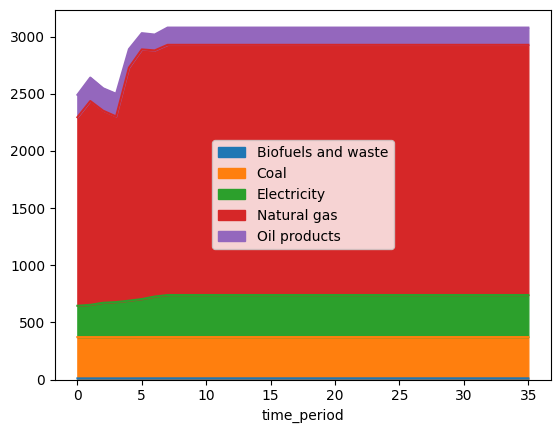

In [648]:
df_scoe_consumption_res.plot.area(x = "time_period")

In [607]:
df_scoe_consumption.drop(columns = ["time_period"]).sum(axis = 1).head()





0    2947.181
1    2947.181
2    3117.331
3    3117.331
4    3006.738
dtype: float64

0    4990.425617
1    4993.290560
2    4995.781858
3    4991.205328
4    4982.771952
dtype: float64


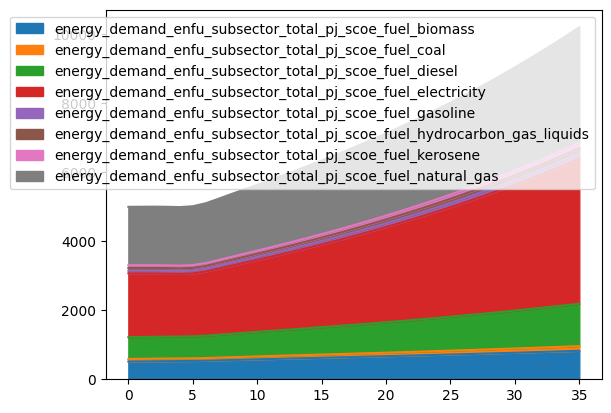

In [606]:
df = matt.extract_model_variable(
    df_outputs,
    modvar_scoe_energy_demand,
)
fields_drop = [x for x in df.columns if df[x].max() == 0.0]

(
    df
    .drop(columns = fields_drop)
    .plot
    .area()
)

print(df.sum(axis = 1).head())

# DO SOME QUICK AND DIRTY REBALANCING

In [608]:
scalar = 4990.425617/2947.181


#df = dict_files.get("industry total final consumption by source")
#df = dict_files.get("commercial and public services total final consumption by source")
df = dict_files.get("residential total final consumption by source")
dict_res = df[df["Year"].isin([time_periods.all_years[0]])]#["Value"].sum()/1000# + df2[df2["Year"].isin([2022])]["Value"].sum()/1000
dict_res = sf.build_dict(dict_res[["residential total final consumption by source in Iran", "Value"]])
demand_res_heat_gj = (sum(dict_res.values()) - dict_res.get("Electricity")/2)*1000
demand_heat_per_hh_init = demand_res_heat_gj/vec_num_hh[0]
demand_appl_per_hh_init = 1000*dict_res.get("Electricity")/2
demand_appl_per_hh_init = demand_appl_per_hh_init/vec_num_hh[0]



modvar = matt.get_variable("SCOE Initial Per Household Electric Appliances Energy Consumption")
#df_inputs[modvar.fields[0]] = demand_appl_per_hh_init



df_fracs_res = matt.extract_model_variable(
    df_inputs,
    
)

In [635]:
def get_dict_enfu_cat_to_scoe_vars(
    model_enercons: 'EnergyConsumption',
) -> dict:
    """
    Map enfu categories to fuel fraction variables. Builds the following
        dictionaries

        * dict_cat_enfu_to_scoe_heat_fuel_fraction
        * dict_cat_enfu_to_scoe_heat_fuel_efficiency
    """
    # some initialization
    dict_fuel_frac_to_eff = model_enercons.modvar_dict_scoe_fuel_fractions_to_efficiency_factors
    matt = model_enercons.model_attributes
    
    pycatdisp_enfu = matt.get_subsector_attribute(
        matt.subsec_name_enfu, 
        "pycategory_primary_element",
    )


    ##  BUILD DICTS

    # init
    dict_cat_enfu_to_scoe_heat_fuel_fraction = {}
    dict_cat_enfu_to_scoe_heat_fuel_efficiency = {}
    
    for k, v in dict_fuel_frac_to_eff.items():

        modvar_frac = matt.get_variable(k)
        modvar_eff = matt.get_variable(v)

        key_new = modvar_frac.get_property(pycatdisp_enfu)
        key_new = sfs.ma.clean_schema(key_new)

        dict_cat_enfu_to_scoe_heat_fuel_fraction.update({key_new: modvar_frac})
        dict_cat_enfu_to_scoe_heat_fuel_efficiency.update({key_new: modvar_eff})

    
    out = (
        dict_cat_enfu_to_scoe_heat_fuel_fraction,
        dict_cat_enfu_to_scoe_heat_fuel_efficiency,
    )

    return out








In [ ]:
def select_iea_match_field_by_fuel(
    df_cw: 
) -> dict:
    """
    Select a grouping to use in aggregation and scaling based on 
        available IEA fields

    Function ARgume
    """

In [636]:
def rescale_scoe_to_iea(
    df_inputs: pd.DataFrame,
    df_scoe_consumption_cps: pd.DataFrame,
    df_scoe_consumption_res: pd.DataFrame,
    model_enercons: 'EnergyConsumption',
    df_outputs: Union[pd.DataFrame, None] = None,
) -> pd.DataFrame:
    """
    Rescale some inputs to SSP to better match outputs in df_scoe_consumption
    """

    # retrieve fuel/variable dictionaries
    (
        dict_cat_enfu_to_scoe_heat_fuel_fraction,
        dict_cat_enfu_to_scoe_heat_fuel_efficiency,
    ) = get_dict_enfu_cat_to_scoe_vars(
        model_enercons, 
    )


    


{'fuel_hydrocarbon_gas_liquids': <sisepuede.core.model_variable.ModelVariable at 0x3f62e8110>,
 'fuel_biomass': <sisepuede.core.model_variable.ModelVariable at 0x3a387f290>,
 'fuel_hydrogen': <sisepuede.core.model_variable.ModelVariable at 0x3f62ea890>,
 'fuel_diesel': <sisepuede.core.model_variable.ModelVariable at 0x3f62eb390>,
 'fuel_gasoline': <sisepuede.core.model_variable.ModelVariable at 0x3f62e9410>,
 'fuel_coal': <sisepuede.core.model_variable.ModelVariable at 0x3f62e8750>,
 'fuel_electricity': <sisepuede.core.model_variable.ModelVariable at 0x3f62e8c10>,
 'fuel_kerosene': <sisepuede.core.model_variable.ModelVariable at 0x3a387d1d0>,
 'fuel_natural_gas': <sisepuede.core.model_variable.ModelVariable at 0x3a387c910>}

In [622]:
pycatdisp_enfu = matt.get_subsector_attribute(
    matt.subsec_name_enfu, 
    "pycategory_primary_element",
)
pycatdisp_enfu


'cat_fuel'

In [551]:
modvar1 = matt.get_variable(
    models_noelec.model_enercons.modvar_scoe_frac_heat_en_diesel
)

modvar1.fields


['frac_scoe_heat_energy_commercial_municipal_diesel',
 'frac_scoe_heat_energy_other_se_diesel',
 'frac_scoe_heat_energy_residential_diesel']

In [549]:
[
    x for x in dir(models_noelec.model_enercons)
    if x.startswith("modvar_scoe")
]

['modvar_scoe_consumpinit_energy_per_hh_elec',
 'modvar_scoe_consumpinit_energy_per_hh_heat',
 'modvar_scoe_consumpinit_energy_per_mmmgdp_elec',
 'modvar_scoe_consumpinit_energy_per_mmmgdp_heat',
 'modvar_scoe_demscalar_elec_energy_demand',
 'modvar_scoe_demscalar_heat_energy_demand',
 'modvar_scoe_efficiency_fact_heat_en_coal',
 'modvar_scoe_efficiency_fact_heat_en_diesel',
 'modvar_scoe_efficiency_fact_heat_en_electricity',
 'modvar_scoe_efficiency_fact_heat_en_gasoline',
 'modvar_scoe_efficiency_fact_heat_en_hgl',
 'modvar_scoe_efficiency_fact_heat_en_hydrogen',
 'modvar_scoe_efficiency_fact_heat_en_kerosene',
 'modvar_scoe_efficiency_fact_heat_en_natural_gas',
 'modvar_scoe_efficiency_fact_heat_en_solid_biomass',
 'modvar_scoe_elasticity_hh_energy_demand_electric_to_gdppc',
 'modvar_scoe_elasticity_hh_energy_demand_heat_to_gdppc',
 'modvar_scoe_elasticity_mmmgdp_energy_demand_elec_to_gdppc',
 'modvar_scoe_elasticity_mmmgdp_energy_demand_heat_to_gdppc',
 'modvar_scoe_emissions_ch4',

In [ ]:
def func_name(
    
) -> pd.DataFrame:
    """

    Function Arguments
    ------------------

    Keyword Arguments
    -----------------
    """
    df = matt.extract_model_variable(
        df_outputs,
        ,
    )

In [525]:
df_scoe_consumption.head()

,time_period,Biofuels and waste,Electricity,Natural gas,Oil products
0,0,10.392,139.949,245.817,59.858
1,1,10.392,145.922,268.588,50.421
2,2,10.392,154.831,259.405,34.056
3,3,10.392,155.026,250.763,35.134
4,4,10.392,164.612,295.084,36.271


In [522]:
df_scoe_consumption.head()

,time_period,Biofuels and waste,Coal,Electricity,Natural gas,Oil products
0,0,10.547,0.361,273.974,1649.669,195.975
1,1,10.549,0.361,282.178,1783.025,205.256
2,2,10.552,0.361,300.251,1680.292,195.959
3,3,10.554,0.361,306.355,1624.310,198.314
4,4,10.556,0.361,318.600,2038.584,162.099


###   MinShareProduction

In [438]:
def build_msp_for_single_region(
    dict_files: dict,
    dict_tech_repl: dict,
    model_attributes: 'ModelAttributes',
    time_periods: sc.TimePeriods,
    regions: sc.Regions,
    dataset_iea: do.DatasetIEA = iea_info,
    field_tech: str = FIELD_IEA_TECH_TMP,
    key_dict: str = "electricity generation sources",
    modvar: Union[str, 'ModelVariable'] = "NemoMod MinShareProduction",
) -> pd.DataFrame:
    """
    """

    # categories to keep
    cats_keep = model_attributes.filter_keys_by_attribute(
        matt.subsec_name_entc,
        {
            "power_plant": 1
        }
    )

    df_out = aggregate_and_pivot_iea_fuel_single_region(
        dict_files,
        key_dict,# = "electricity generation sources",
        modvar,# = "NemoMod MinShareProduction",
        model_attributes,
        time_periods,
        regions,
        calculate_proportion = True,
        cats_keep = cats_keep,
        dataset_iea = dataset_iea,
        dict_cat_repl = dict_tech_repl,
        field_tech = field_tech,
    )

    return df_out



df_msp = build_msp_for_single_region(
    dict_files,
    dict_iea_fuel_to_entc_cat,
    matt,
    time_periods,
    regions,
)



0     0.999950
1     0.999917
2     0.999877
3     0.999932
4     0.999945
5     0.999933
6     0.999935
7     0.999937
8     0.999937
9     0.999937
10    0.999937
11    0.999937
12    0.999937
13    0.999937
14    0.999937
15    0.999937
16    0.999937
17    0.999937
18    0.999937
19    0.999937
20    0.999937
21    0.999937
22    0.999937
23    0.999937
24    0.999937
25    0.999937
26    0.999937
27    0.999937
28    0.999937
29    0.999937
30    0.999937
31    0.999937
32    0.999937
33    0.999937
34    0.999937
35    0.999937
dtype: float64

In [440]:
[
    x for x in dir(models_noelec.model_enercons)
    if x.startswith("modvar_enf")
]



In [442]:
dict_files.get("industry total final consumption by source")

,industry total final consumption by source in Iran,Value,Year,Units
0,Coal,10087,2000,TJ
1,Coal,9575,2001,TJ
2,Coal,8438,2002,TJ
3,Coal,11802,2003,TJ
4,Coal,14492,2004,TJ
...,...,...,...,...
87,Electricity,314969,2018,TJ
88,Electricity,345505,2019,TJ
89,Electricity,376346,2020,TJ
90,Electricity,385335,2021,TJ


TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

In [397]:
(
    dict_files
    .get("industry total final consumption by source")
    .get("")
)

,industry total final consumption by source in Iran,Value,Year,Units
0,Coal,10087,2000,TJ
1,Coal,9575,2001,TJ
2,Coal,8438,2002,TJ
3,Coal,11802,2003,TJ
4,Coal,14492,2004,TJ
...,...,...,...,...
87,Electricity,314969,2018,TJ
88,Electricity,345505,2019,TJ
89,Electricity,376346,2020,TJ
90,Electricity,385335,2021,TJ


In [ ]:
dict_iea_fuel_to_enfu_cat

# write to inputs

In [20]:
(
    df_inputs
    .to_csv(
        fp_data_inputs,
        index = None,
        encoding = "UTF-8",
    )
)

# Next, pull in outputs generated from running SISEPUEDE before scaling inputs
- we'll use this to scale IEA

In [25]:
df_out_raw = pd.read_csv(
    dir_data.joinpath("sisepuede_outputs_iran_preiea.csv")
)

key = matt.dim_primary_id
df_out_raw = (
    df_out_raw[
        df_out_raw[key].isin([0])
    ]
    .reset_index(drop = True, )
    .drop(columns = [key])
)

# Read in IEA datasets
- start building a generalizable set of functions to use for integrating IEA datasets from country profiles

In [172]:
#[x for x in matt.all_variables if ("Consumption" in x)]

In [171]:
vec_gdp = matt.extract_model_variable(
    df_inputs,
    "GDP",# "Land Use Area",
    return_type = "array_base"
)

vec_num_hh = matt.extract_model_variable(
    df_out_raw,
    "Number of Households",# "Land Use Area",
    return_type = "array_base"
)

vec_appliance_demand_per_hh = matt.extract_model_variable(
    df_inputs,
    "SCOE Initial Per Household Electric Appliances Energy Consumption",
    return_type = "array_base",
)

vec_heat_demand_per_hh = matt.extract_model_variable(
    df_inputs,
    "SCOE Initial Per Household Heat Energy Consumption",
    return_type = "array_base",
)

"""
matt.get_variable_characteristic(
    "SCOE Initial Per Household Electric Appliances Energy Consumption",
    "unit_energy"
)
"""
# in pj
vec_appliance_demand_res = vec_appliance_demand_per_hh*vec_num_hh/10**6
vec_heat_demand_res = vec_heat_demand_per_hh*vec_num_hh/10**6

In [189]:
vec_heat_demand_per_hh
vec_appliance_demand_per_hh


array([ 84.9097254 ,  84.46722356,  84.02472405,  83.58222384,
        83.13972392,  83.27804558,  83.84806242,  84.41808684,
        84.98811866,  85.5581577 ,  88.08300372,  90.75350048,
        93.42385872,  96.09407616,  98.76416421, 101.73120343,
       104.79724502, 107.86318038, 110.92901094, 113.9947381 ,
       117.28422666, 120.64998857, 124.01566787, 127.38126547,
       130.74678229, 133.8865539 , 137.16058022, 140.43456465,
       143.70850751, 146.98240915, 149.85046572, 152.9283556 ,
       156.0062367 , 159.08410906, 158.88904297, 158.69445466])

In [ ]:
df_inputs.to_csv(
    fp_data_inputs_modified,
    index = None,
    encoding = "UTF-8"
)

In [198]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["costa_rica"],
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-05 00:54:45,039 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-05 00:54:45,039 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-05 00:54:45,041 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-05 00:54:45,041 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-05 00:54:45,042 - INFO - 	Setting export engine to 'csv'.
2024-11-05 00:54:45,042 - INFO - 	Setting export engine to 'csv'.
2024-11-05 00:54:45,043 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-05 00:54:45,043 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-05 00:54:45,043 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-11-05 00:54:45,043 - INFO - Successfully

[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Using Julia 1.11.1 at /Users/usuario/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/bin/julia
[juliapkg] Using Julia project at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="Cbc", uuid="9961bab8-2fa3-5c5a-9d89-47fab24efd76"), Pkg.PackageSpec(name="Clp", uuid="e2554f3b-3117-50c0-817c

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.11.0
  [b6b21f68] + Ipopt v1.6.7
  [4076af6c] + JuMP v1.23.3
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
⌅ [6099a3de] + PythonCall v0.9.22
  [0aa819cd] + SQLite v1.6.1
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.23
  [88353bc9] + ConfParser v0.1.2
  [a8cc5b0e] + Crayons v4.1.1
  

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1259.5 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-05 00:55:28,152 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-05 00:55:28,152 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-05 00:55:28,165 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-05 00:55:28,165 - INFO - Succ

In [214]:
df_outputs = ssp.models.project(df_inputs)

2024-11-05 00:56:54,921 - INFO - Running AFOLU model
2024-11-05 00:56:54,921 - INFO - Running AFOLU model
2024-11-05 00:56:55,043 - INFO - AFOLU model run successfully completed
2024-11-05 00:56:55,043 - INFO - AFOLU model run successfully completed
2024-11-05 00:56:55,044 - INFO - Running CircularEconomy model
2024-11-05 00:56:55,044 - INFO - Running CircularEconomy model
2024-11-05 00:56:55,073 - INFO - CircularEconomy model run successfully completed
2024-11-05 00:56:55,073 - INFO - CircularEconomy model run successfully completed
2024-11-05 00:56:55,074 - INFO - Running IPPU model
2024-11-05 00:56:55,074 - INFO - Running IPPU model
2024-11-05 00:56:55,115 - INFO - IPPU model run successfully completed
2024-11-05 00:56:55,115 - INFO - IPPU model run successfully completed
2024-11-05 00:56:55,115 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-05 00:56:55,115 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-05 0

2024-05-Nov 00:56:55.531 Opened SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-05-Nov 00:56:55.668 Added NEMO structure to SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-05-Nov 00:57:02.049 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-05 00:57:32,520 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-05 00:57:32,520 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-05 00:57:32,528 - INFO - EnergyProduction model run successfully completed
2024-11-05 00:57:32,528 - INFO - EnergyProduction model run successfully completed
2024-11-05 00:57:32,529 - INFO - Running Energy (Fugitive Emissions)
2024-11-05 00:57:32,529 - INFO - Running Energy (Fugitive Emissions)
2024-11-05 00:57:32,550 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-05 00:57:32,550 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-05 00:57:32,550 - INFO - Appending Socioeconomic outputs
2024-11-05 00:57:32,550 - INFO - Appending Socioec

2024-05-Nov 00:57:32.426 Finished modeling scenario.


<Axes: >

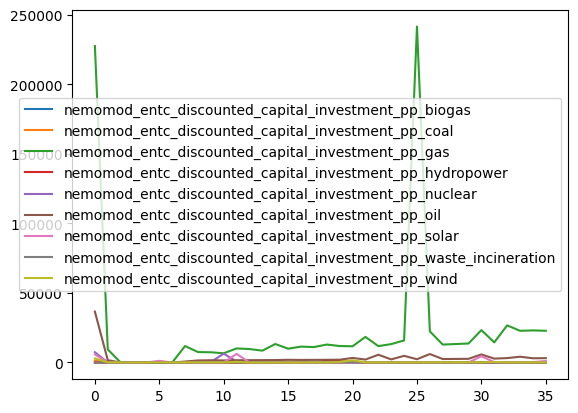

In [220]:

df_prim = df_outputs
df_in_cur = df_inputs


fields_plot = [
    x for x in df_prim.columns
    if "investment" in x
    and df_prim[x].max() > 0
]
(
    df_prim[fields_plot]
    .plot(
        legend = True,
    )
)




In [139]:
matt.extract_model_variable(
    df_out_raw,
    "Energy Demand by Fuel in SCOE"#Industrial Energy"
).iloc[7]

energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                      0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                     546.753417
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         78.779258
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                          0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                      662.233684
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                3556.017787
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                     82.779210
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                    0.000000
energy_demand_enfu_subsector_total_pj_scoe_

In [131]:
dict_files.keys()

dict_keys(['transport total final consumption by source', 'industry total final consumption by source', 'total final energy consumption', 'commercial and public services total final consumption by source', 'residential total final consumption by source', 'electricity generation sources'])

In [138]:
df = dict_files.get("industry total final consumption by source")
df = dict_files.get("commercial and public services total final consumption by source")
df2 = dict_files.get("residential total final consumption by source")
df[df["Year"].isin([2022])]["Value"].sum()/1000 + df2[df2["Year"].isin([2022])]["Value"].sum()/1000

3258.703

##  Build MSP

In [98]:


"""


df_electricity_generation_share_g = (
    df_electricity_generation_share
    .groupby(["Year", ])
)


data_electricity_generation_share = do.DatasetIEA(
    df_electricity_generation_share
)
"""
build_msp(dict_files)["Fuel"].unique()


#df_electricity_generation_share["Value"] = df_electricity_generation_share["Value"]/df_electricity_generation_share["Value"].sum()
#df_electricity_generation_share

#data_electricity_generation_share.df

array(['Coal', 'Oil', 'Natural gas', 'Nuclear', 'Hydro', 'Biofuels',
       'Wind', 'Solar PV'], dtype=object)

True

In [99]:
matt.get_attribute_table("Energy Technology")

,category_name,cat_technology,description,data_source,hyperlink,notes,operational_life,technology_from_storage,technology_to_storage,electricity_generation_cat_fuel,cat_storage,generates_fuel_cat_fuel,fuel_processing,mining_and_extraction,power_plant,storage,renewable_default
0,Fuel Production - Ammonia,fp_ammonia_production,Ammonia production using the Haber-Bosch proce...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
1,Fuel Production - Hydrogen Electrolysis,fp_hydrogen_electrolysis,"Hydrogen generation from electrolysis, which r...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
2,Fuel Production - Hydrogen from Coal Gasification,fp_hydrogen_gasification,Hydrogen generation from fossil-fuel driven th...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
3,Fuel Production - Hydrogen Steam Methane Refor...,fp_hydrogen_reformation,Hydrogen generation from steam-methane reforma...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
4,Fuel Production - Hydrogen Steam Methane Refor...,fp_hydrogen_reformation_ccs,Hydrogen generation from steam-methane reforma...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
5,Fuel Production - Natural Gas,fp_natural_gas,"Natural gas processing, which refines unproces...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
6,Fuel Production - Petroleum Refinement,fp_petroleum_refinement,"Oil refinery technology, which produce inputs ...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
7,Mining and Exploration - Coal,me_coal,Coal mining and extraction; produces ``fuel_co...,NaN,NaN,NaN,100,none,none,none,none,``fuel_coal``,0,1,0,0,0
8,Mining and Exploration - Crude,me_crude,Crude oil exploration and extraction; produces...,NaN,NaN,NaN,100,none,none,none,none,``fuel_crude``,0,1,0,0,0
9,Mining and Exploration - Natural Gas,me_natural_gas,Natural gas exploration and extraction; produc...,NaN,NaN,NaN,100,none,none,none,none,``fuel_natural_gas_unprocessed``,0,1,0,0,0


In [60]:
#df_electricity_generation_share
dir(data_electricity_generation_share)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_initialize_data_frame',
 '_initialize_fields',
 '_initialize_melt_fields',
 '_initialize_reader_specification',
 '_subset',
 'df',
 'dict_field_definition',
 'field_keys',
 'field_units',
 'field_value',
 'field_year',
 'fields',
 'fields_integer',
 'file_read_specification',
 'get_integer_fields',
 'get_subset',
 'melt_by_subset',
 'read']

In [398]:
df_inputs

,time_period,ef_enfu_combustion_tonne_co2_per_tj_fuel_water,ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_water,ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_water,cost_enfu_fuel_ammonia_usd_per_tonne,ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia,ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia,ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia,ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia,exports_enfu_pj_fuel_ammonia,...,va_mining_mmm_usd,va_manufacturing_mmm_usd,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_tonne,demscalar_ippu_recycled_metals,va_industrial_mmm_usd,demscalar_ippu_recycled_textiles,demscalar_ippu_recycled_rubber_and_leather,va_commercial_mmm_usd,demscalar_ippu_recycled_plastic,region
0,0,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,2.954671,6.239061,1530,1,10.648961,1,1,38.831074,1,iran
1,1,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.080127,6.518428,1530,1,10.939956,1,1,40.739526,1,iran
2,2,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.183768,6.936926,1530,1,11.224979,1,1,42.253987,1,iran
3,3,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.266670,7.196583,1530,1,11.809202,1,1,43.092214,1,iran
4,4,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.361589,7.402811,1530,1,12.144927,1,1,44.391061,1,iran
5,5,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.455924,7.607812,1530,1,12.479776,1,1,45.677420,1,iran
6,6,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.560141,7.833482,1530,1,12.849972,1,1,47.091702,1,iran
7,7,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.671422,8.074161,1530,1,13.246047,1,1,48.595983,1,iran
8,8,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.794604,8.340167,1530,1,13.684969,1,1,50.255204,1,iran
9,9,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.929847,8.632126,1530,1,14.167676,1,1,52.071246,1,iran
